In [1]:
import os
import datetime
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import fish2bird

def showimage(image):
    plt.figure(figsize=(16, int(16*image.shape[0]/image.shape[1])))
    plt.imshow(image, cmap="gray")
    plt.show()

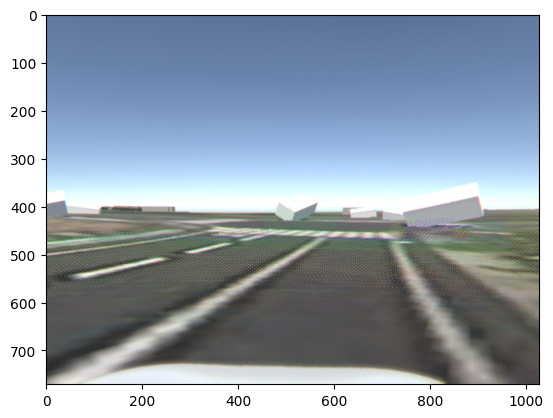

In [2]:
#image = cv.cvtColor(cv.imread("img-41408800479400.png"), cv.COLOR_BGR2RGB)
image = cv.cvtColor(cv.imread("../../data/distances/1666173326227.png"), cv.COLOR_BGR2RGB)
#image = cv.cvtColor(cv.imread("../../test.png"), cv.COLOR_BGR2RGB)

plt.imshow(image, cmap="gray")
plt.show()

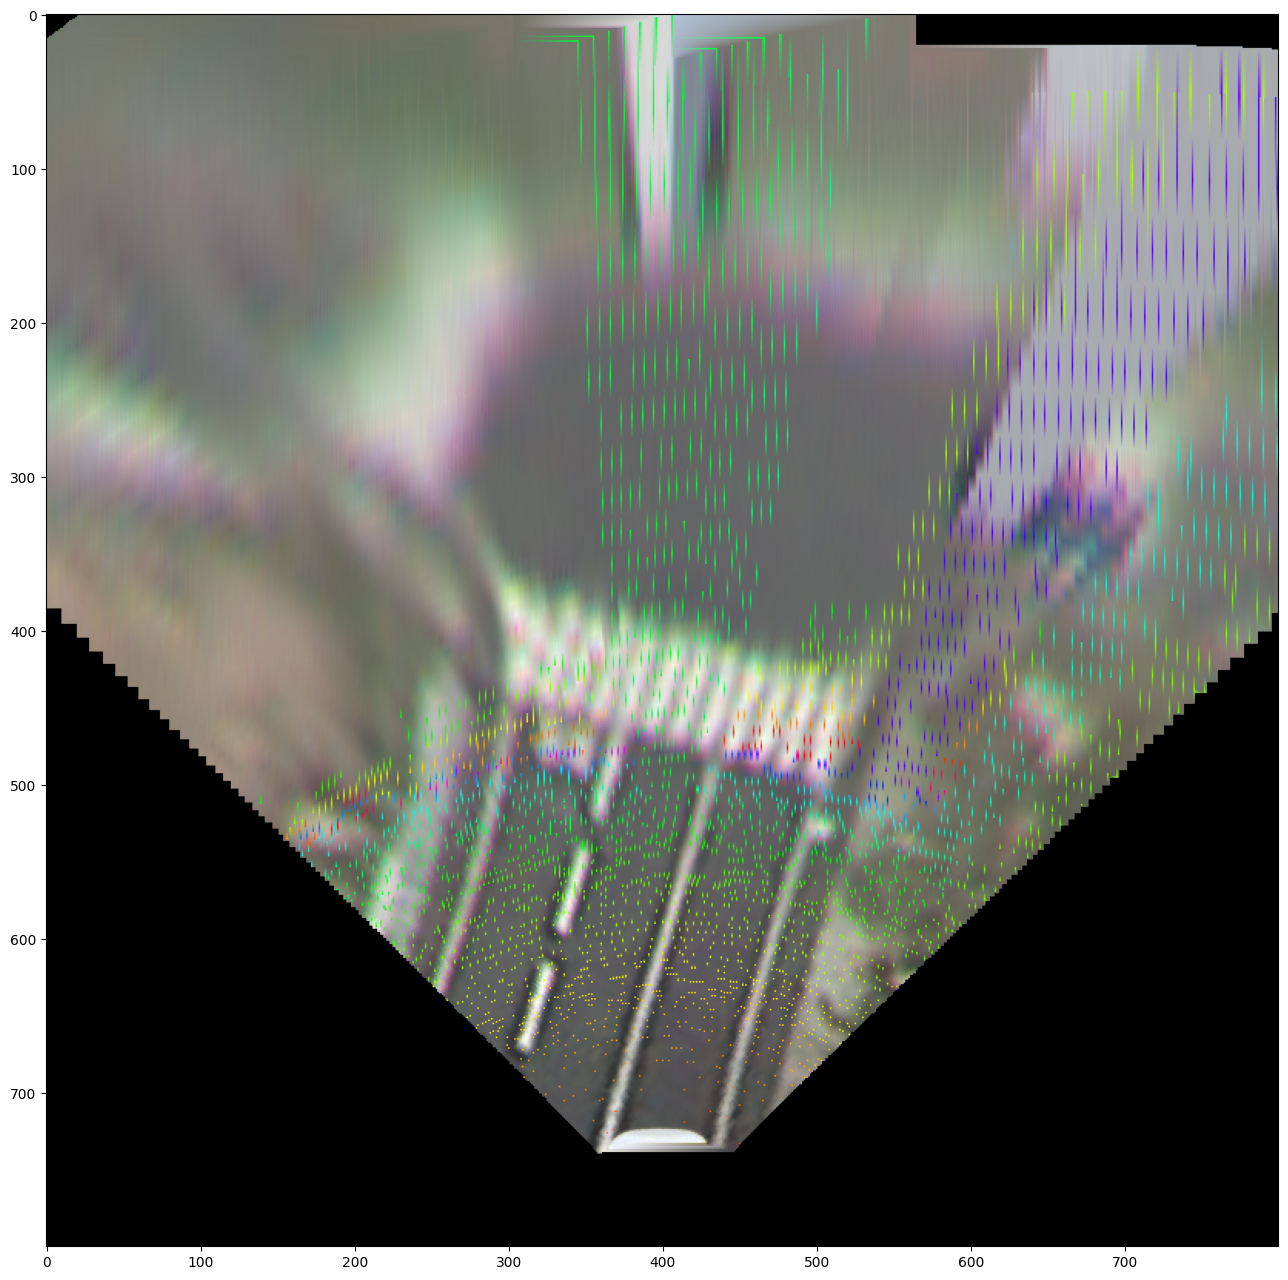

In [3]:
camera_to_target = np.asarray(((0.9999200,  0.0112578, -0.0057689, 0.054),
                               (0.0055449,  0.0198313,  0.9997880, 1.162),
                               (0.0113699, -0.9997399,  0.0197672, 1.578),
                               (0.       ,  0.       ,  0.       , 1.   )))
camera_to_image = np.asarray(((1124.66943,    0      , 505.781982),
                              (   0      , 1124.61658, 387.811005),
                              (   0      ,    0      ,   1       )))
xi = 0.8803200125694275
range_x = (-20, 20)
range_y = (0, 40)

birdeye, scale_factor = fish2bird.to_birdeye(image, camera_to_image, camera_to_target, xi, range_x, range_y, 800, flip_y=True)
meter = 1/scale_factor
showimage(birdeye)

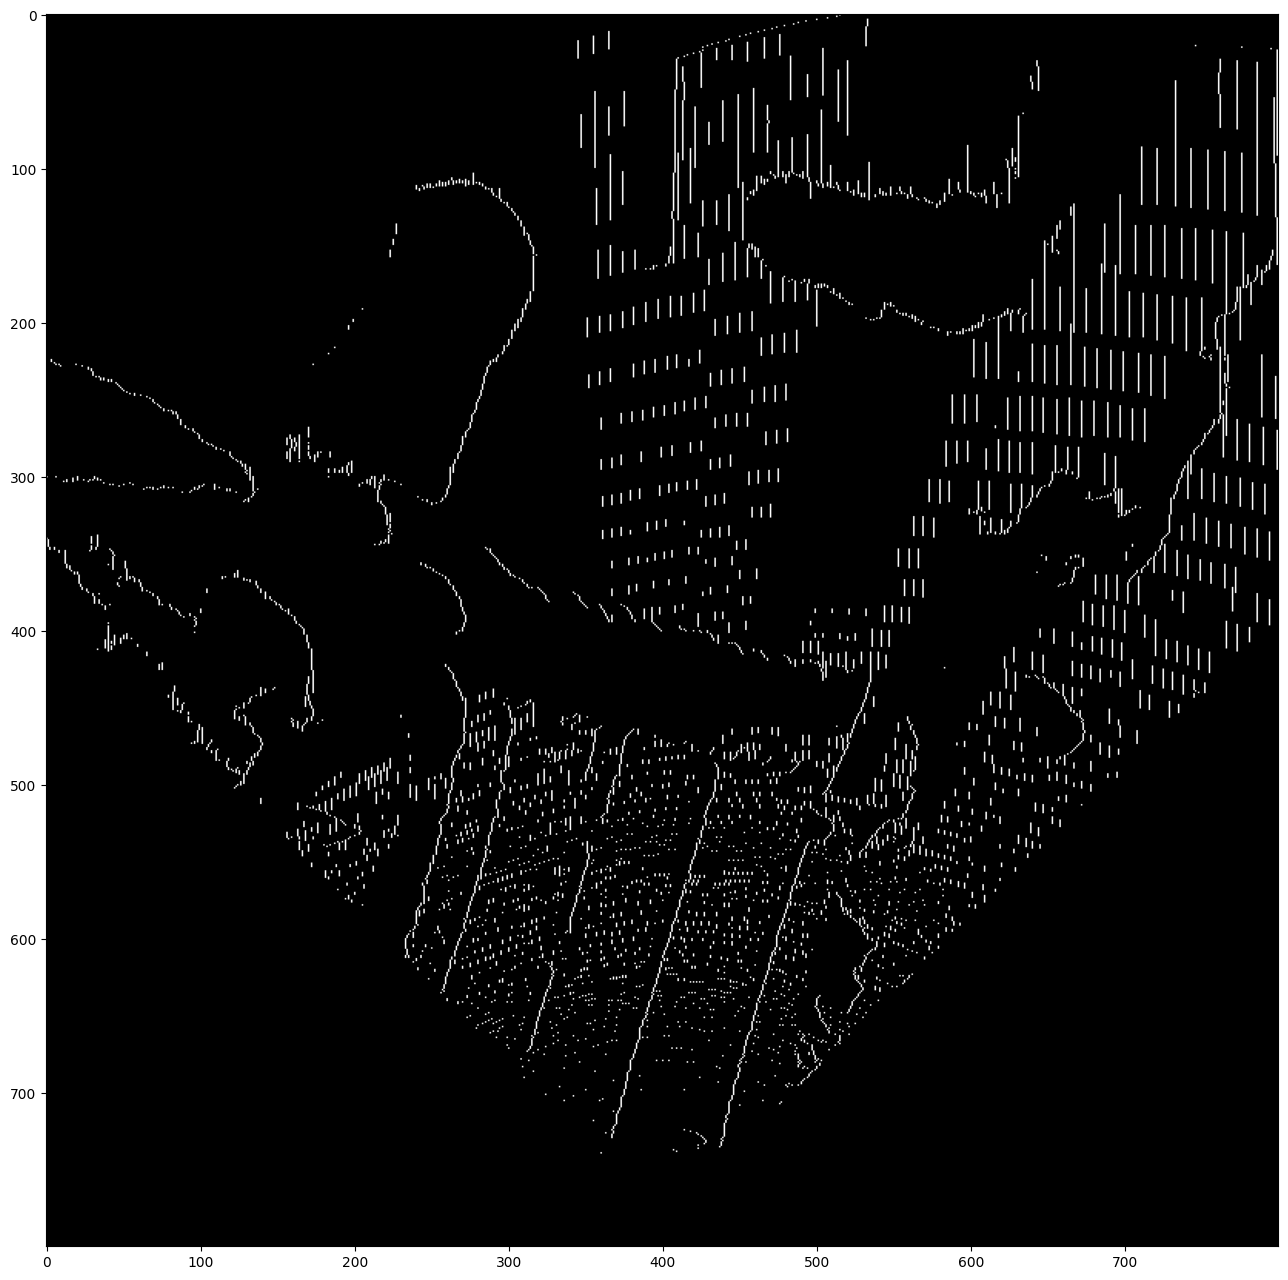

In [4]:
be_gray = cv.cvtColor(birdeye, cv.COLOR_RGB2GRAY)
be_blur = be_gray# = cv.GaussianBlur(be_gray, (5, 5), 0)
threshold, _ = cv.threshold(be_blur[be_blur > 0], 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
threshold, be_binary = cv.threshold(be_blur, threshold, 255, cv.THRESH_BINARY)
#tophat_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (int(meter*0.5), int(meter*0.4)))
#closing_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (int(meter), int(meter)))
#be_binary = cv.morphologyEx(be_binary, cv.MORPH_TOPHAT, tophat_kernel)
#opening_kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
#be_binary = cv.dilate(cv.erode(be_binary, opening_kernel), opening_kernel)
#closing_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (int(meter), int(meter)))
#be_binary = cv.erode(cv.dilate(be_binary, closing_kernel), closing_kernel)
hmkernel = np.asarray(((0, 0,  0),
                       (0, 1, -1),
                       (0, 0,  0)))
be_binary = cv.morphologyEx(be_binary, cv.MORPH_HITMISS, hmkernel)
showimage(be_binary)
#print(np.unique(be_binary))


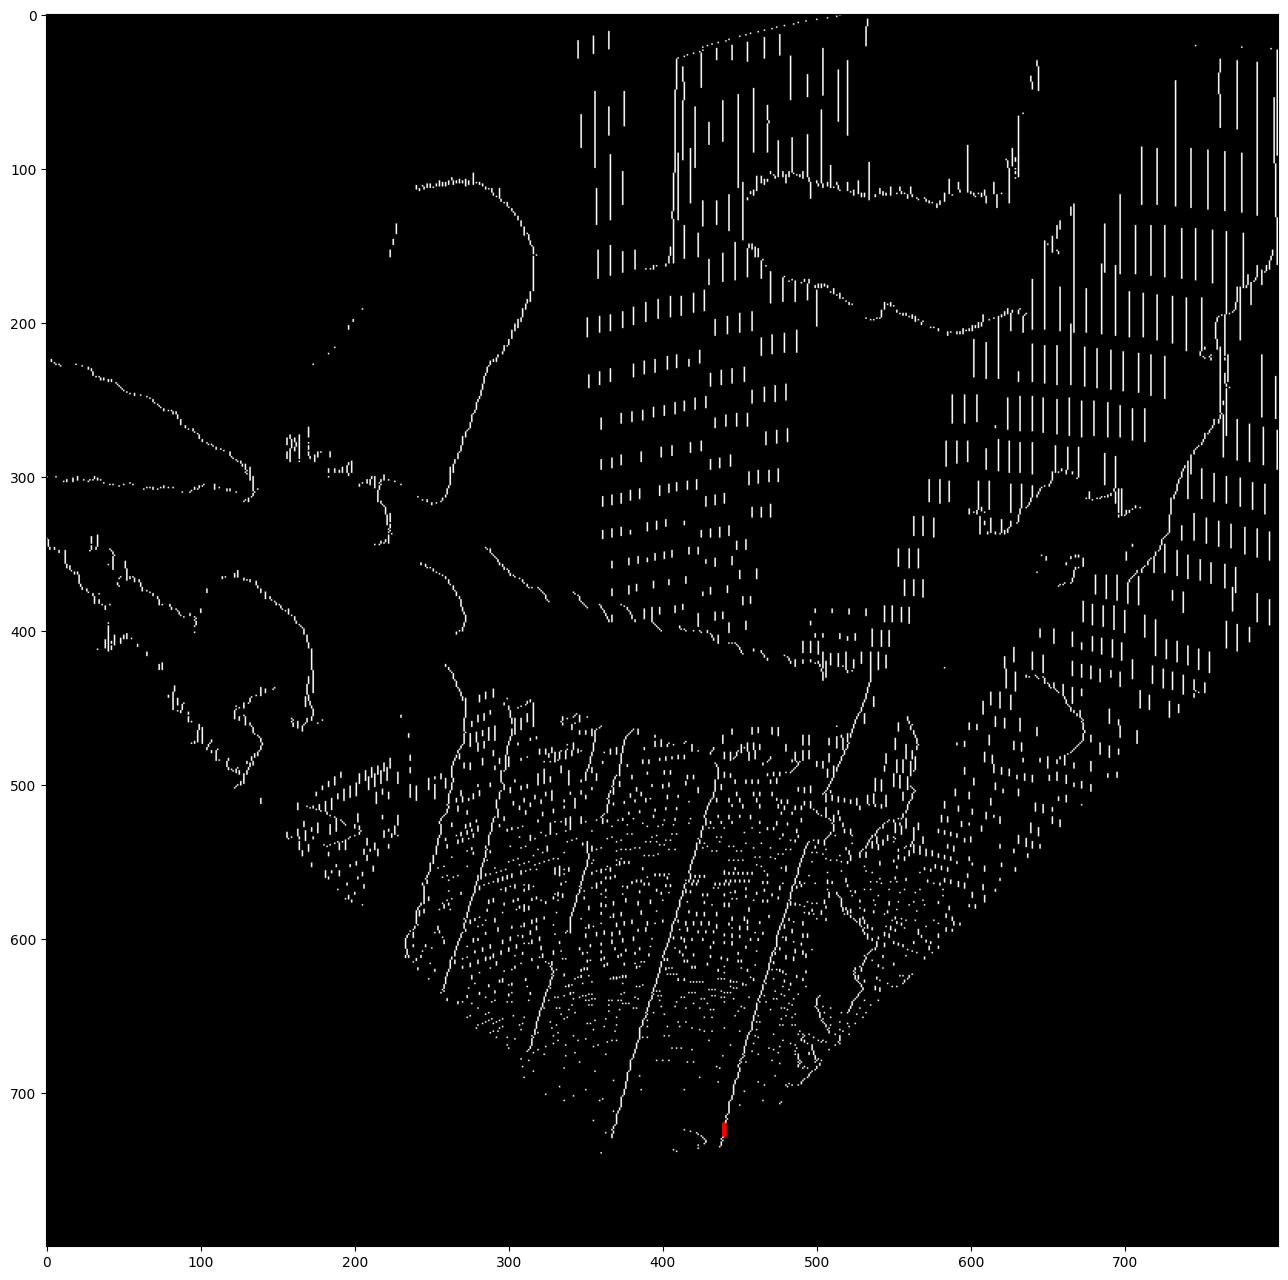

In [5]:
nonempty = np.nonzero(np.sum(be_binary, axis=1))[0]
closest_nonempty = nonempty[np.argmax(nonempty)]
for check_y in np.arange(closest_nonempty, meter, -meter):
    segment = be_binary[int(check_y-meter):int(check_y)]
    lines = cv.HoughLinesP(segment, 4, np.pi/90, int(meter/8), minLineLength=int(meter/4))
    if lines is not None:
        lines = lines[:, 0, :]
        if len(lines) > 0:
            reverse_filter = np.maximum(lines[:, 1], lines[:, 3]) == lines[:, 3]
            lines[reverse_filter, 1], lines[reverse_filter, 3] = lines[reverse_filter, 3], lines[reverse_filter, 1]
            # Now the first point is always the bottom one
            line_angles = np.arctan2(lines[:, 1] - lines[:, 3], lines[:, 0] - lines[:, 2])
            is_right = lines[:, 0] >= be_binary.shape[1] / 2
            is_vertical = (0.2*np.pi/2 < line_angles) & (line_angles < 1.2*np.pi/2)
            candidate_lines = lines[is_right & is_vertical]
            if len(candidate_lines) > 0:
                line_bootstrap = candidate_lines[np.argmax(candidate_lines[:, 0])]
                line_bootstrap[1] += check_y - meter
                line_bootstrap[3] += check_y - meter
                break
else:
    print("No bootstrap found !")

viz = cv.merge((be_binary, be_binary, be_binary))
cv.line(viz, (line_bootstrap[0], int(line_bootstrap[1])), (line_bootstrap[2], int(line_bootstrap[3])), (255, 0, 0), 2)
showimage(viz)

[ 0.20895824 -0.97792456] [595.45868946   0.        ]
[ 0.24670959 -0.96908946] [624.12765345   0.        ]
[ 0.2752637  -0.96136876] [646.19394804   0.        ]
[ 0.27588359 -0.96119105] [647.05928308   0.        ]
[ 0.29109654 -0.95669368] [658.15117471   0.        ]
[ 0.31400061 -0.94942278] [675.12477882   0.        ]
[ 0.26326691 -0.96472304] [637.99481681   0.        ]
[ 0.34765478 -0.93762261] [700.61240331   0.        ]
[ 0.29136659 -0.95661147] [658.40414159   0.        ]
[ 0.18698041 -0.98236364] [589.32361959   0.        ]
[ 0.22514511 -0.97432524] [615.25770616   0.        ]
[ 0.29054945 -0.95685998] [657.3027643   0.       ]
[ 0.30392099 -0.95269724] [667.02633126   0.        ]
[ 0.28001675 -0.95999511] [651.19716156   0.        ]
[ 0.46968846 -0.88283223] [783.98299338   0.        ]


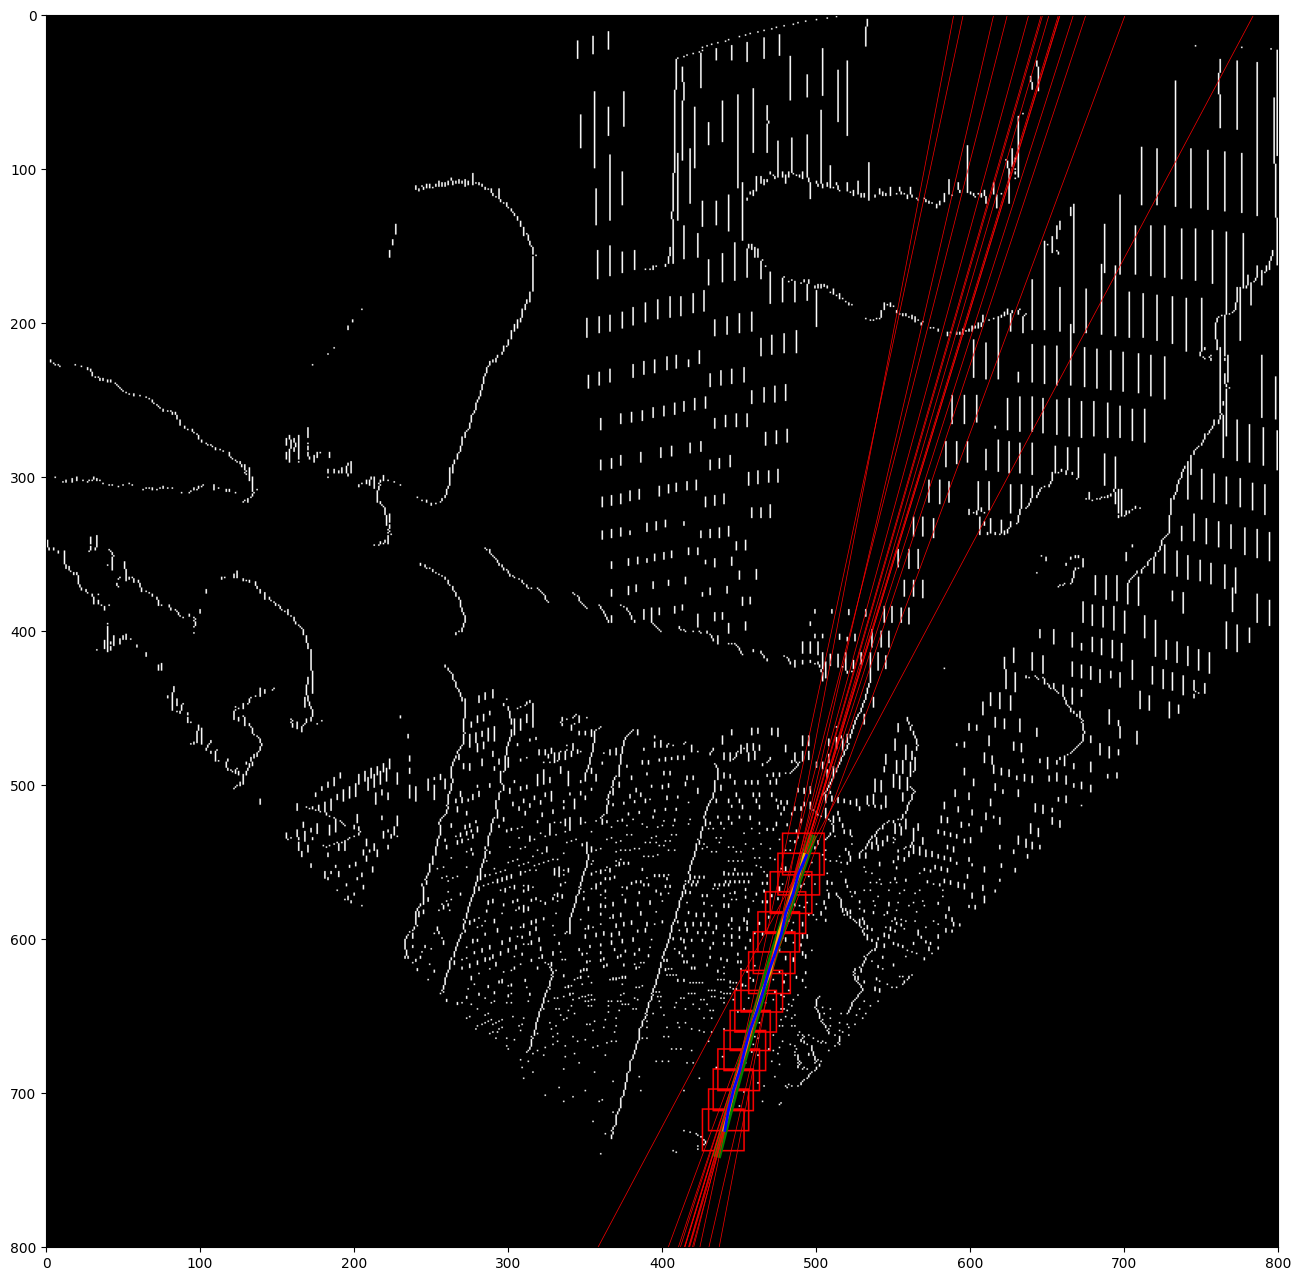

In [6]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

window_size = meter/1.5
window_count = 15
viz = cv.merge((be_binary, be_binary, be_binary))

lines = []
centers = []
projections = []
window_center = np.asarray(((line_bootstrap[2] + line_bootstrap[0])/2, (line_bootstrap[3] + line_bootstrap[1])/2))
for i in range(window_count):
    ystart = int(window_center[1] - window_size)
    yend = int(window_center[1] + window_size)
    xstart = int(window_center[0] - window_size)
    xend = int(window_center[0] + window_size)
    cv.rectangle(viz, (xstart, ystart), (xend, yend), (255, 0, 0), 1)
    window = be_binary[ystart:yend, xstart:xend]
    window_points = np.flip(np.asarray(np.nonzero(window > 0))).astype(float)
    window_points += window_center.reshape((2, 1)) - window_size
    if window_points.shape[1] < 2:
        window_center += director_vector * window_size
        centers.append(window_center)
        projections.append(window_center)
        continue
        
    eigenvalues, eigenvectors = np.linalg.eig(np.cov(window_points))
    eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
    regressor = RANSACRegressor(estimator=LinearRegression())
    if np.abs(eigenvector[1]) > np.abs(eigenvector[0]):
        regressor.fit(window_points[1].reshape(-1, 1), window_points[0].reshape(-1, 1))
        x_slope = regressor.estimator_.coef_[0, 0]
        x_intercept = regressor.estimator_.intercept_[0]

        director_vector = -np.asarray((x_slope, 1)) / np.linalg.norm((x_slope, 1))
        reference_point = np.asarray((x_intercept, 0))
    else:
        regressor.fit(window_points[0].reshape(-1, 1), window_points[1].reshape(-1, 1))
        y_slope = regressor.estimator_.coef_[0, 0]
        y_intercept = regressor.estimator_.intercept_[0]

        director_vector = np.asarray((1, y_slope)) / np.linalg.norm((1, y_slope))
        reference_point = np.asarray((0, y_intercept))
    
    print(director_vector, reference_point)
    
    window_center_projection = (np.dot((window_center - reference_point), director_vector) / np.dot(director_vector, director_vector)) * director_vector + reference_point
    
    lines.append((director_vector, reference_point))
    centers.append(window_center)
    projections.append(window_center_projection)
    window_center = window_center_projection + director_vector * window_size

projections = np.asarray(projections).transpose()
centers = np.asarray(centers).transpose()

plt.figure(figsize=(16, 16))
plt.imshow(viz)
plt.xlim([0, viz.shape[1]])
plt.ylim([viz.shape[0], 0])

t = np.arange(0, projections.shape[1], 1)
xpoly = np.polynomial.Polynomial.fit(t, projections[0], deg=2)
ypoly = np.polynomial.Polynomial.fit(t, projections[1], deg=2)

roots = (ypoly - closest_nonempty).roots()
start_t = roots[np.argmin(np.abs(roots))]
t = np.arange(start_t, window_count, 0.5)
x = xpoly(t)
y = ypoly(t)
plt.plot(x, y, color="green", linewidth=6)

t = np.arange(-viz.shape[1]*2, viz.shape[1]*2, 1)
for director_vector, reference_point in lines:
    x = director_vector[0] * t + reference_point[0]
    y = director_vector[1] * t + reference_point[1]
    plt.plot(x, y, color="red", linewidth=0.5)

plt.plot(centers[0], centers[1], color="orange", linewidth=2)
plt.plot(projections[0], projections[1], color="blue", linewidth=2)

plt.show()

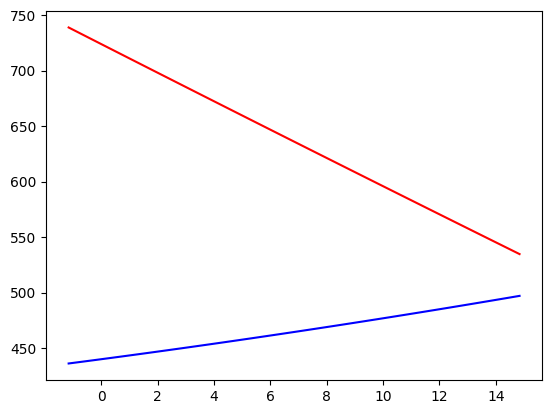

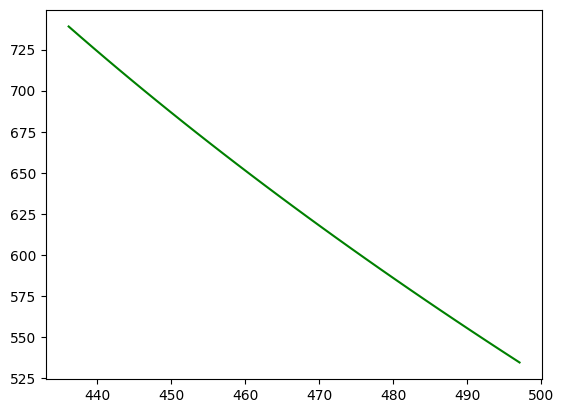

In [7]:
t = np.arange(start_t, window_count, 0.5)
plt.plot(t, xpoly(t), color="blue")
plt.plot(t, ypoly(t), color="red")
plt.show()
plt.plot(xpoly(t), ypoly(t), color="green")
plt.show()

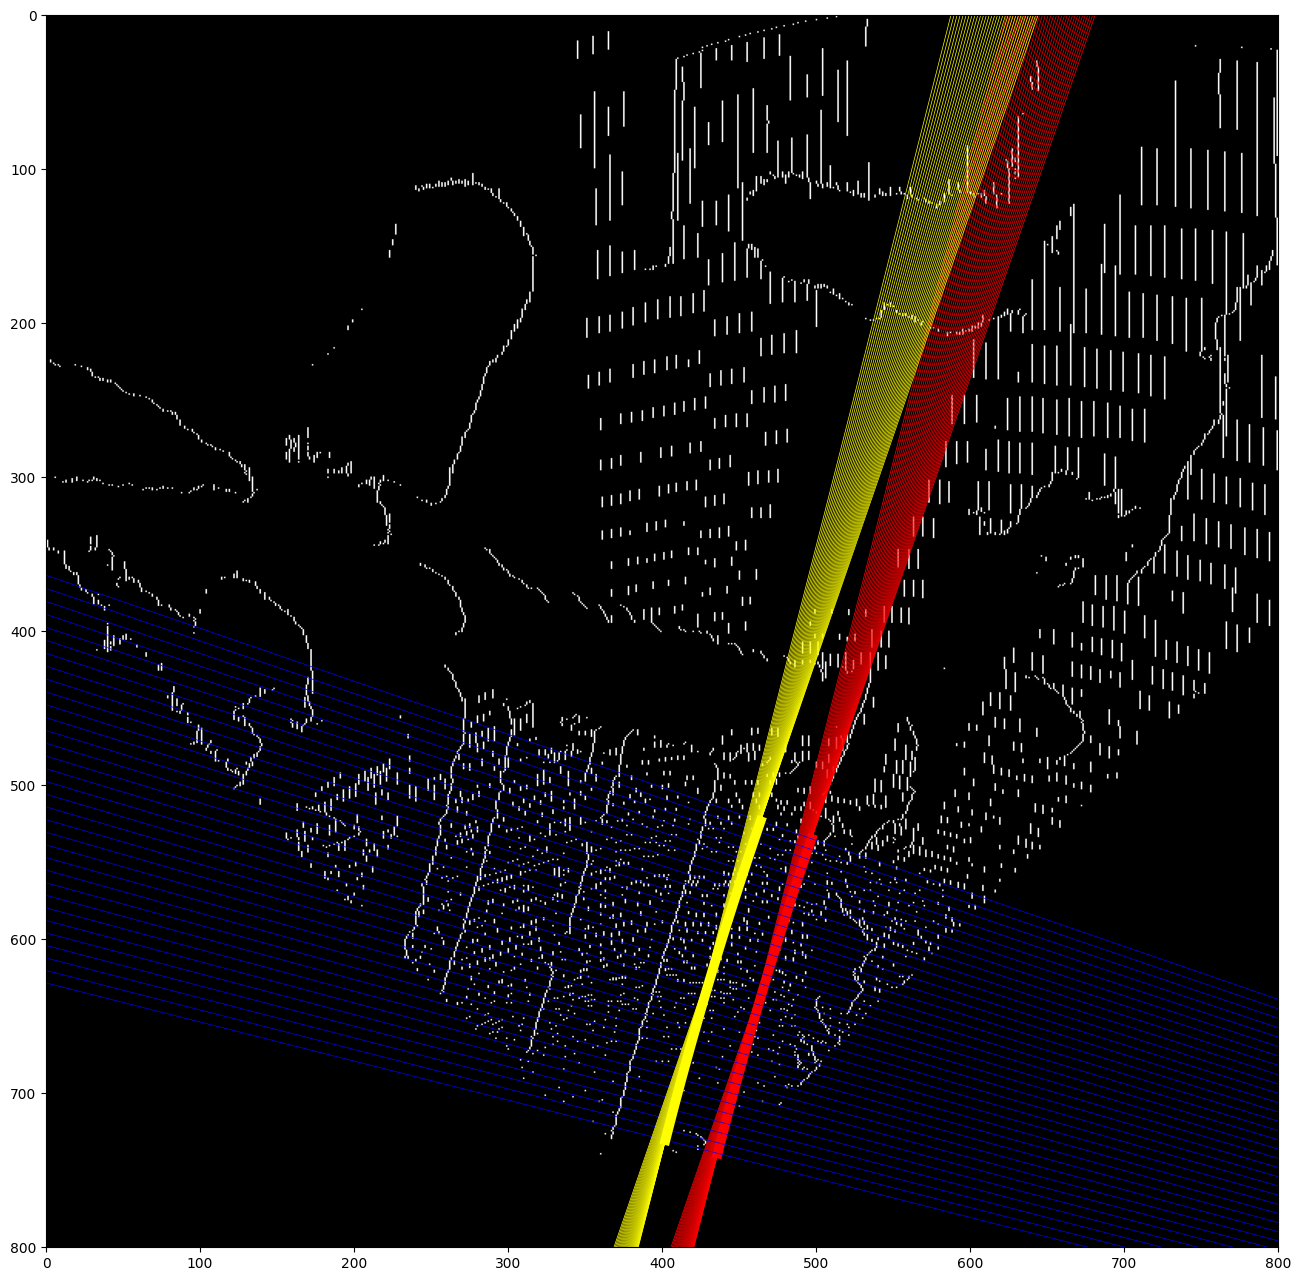

In [8]:
LANE_WIDTH = 3.5 / scale_factor
origin_distance = LANE_WIDTH / 2

t = np.arange(start_t, window_count, 0.5)
xdiff = xpoly.deriv()
ydiff = ypoly.deriv()
xdiff_values = xdiff(t)
ydiff_values = ydiff(t)

tangent_vectors = np.asarray((xdiff_values, ydiff_values))
tangent_vectors /= np.linalg.norm(tangent_vectors, axis=0)

orthogonal_vectors = np.asarray((tangent_vectors[1], -tangent_vectors[0]))
polynomial_values = np.asarray((xpoly(t), ypoly(t)))
trajectory_points = polynomial_values + orthogonal_vectors * origin_distance

txpoly = np.polynomial.Polynomial.fit(t, trajectory_points[0], deg=3)
typoly = np.polynomial.Polynomial.fit(t, trajectory_points[1], deg=3)

plt.figure(figsize=(16, 16))
plt.imshow(be_binary, cmap="gray")
plt.xlim([0, be_binary.shape[1]])
plt.ylim([be_binary.shape[0], 0])
plt.plot(xpoly(t), ypoly(t), color="red", linewidth=7)

s = np.arange(-be_binary.shape[0], be_binary.shape[0], 1)
for vector, intercept in zip(tangent_vectors.transpose(), polynomial_values.transpose()):
    plt.plot(vector[0]*s + intercept[0], vector[1]*s + intercept[1], color="red", linewidth=0.5)

for vector, intercept in zip(orthogonal_vectors.transpose(), polynomial_values.transpose()):
    plt.plot(vector[0]*s + intercept[0], vector[1]*s + intercept[1], color="blue", linewidth=0.5)
    
for vector, intercept in zip(tangent_vectors.transpose(), trajectory_points.transpose()):
    plt.plot(vector[0]*s + intercept[0], vector[1]*s + intercept[1], color="yellow", linewidth=0.5)

plt.plot(trajectory_points[0], trajectory_points[1], color="green", linewidth=2)
plt.plot(txpoly(t), typoly(t), color="yellow", linewidth=7)
    
plt.show()